#Overview of RAG (Retrieval-Augmented Generation)

RAG combines retrieval of relevant documents with generative models to answer questions based on the retrieved information. This approach enhances the accuracy and relevance of responses by leveraging external data sources.
Key Concepts

Retrievers: These are mechanisms that fetch relevant documents from a Vector store based on a query. They can be fine-tuned to improve search results 27.
Vector Store: A database that stores embeddings of documents, allowing for efficient similarity searches 28.
Embeddings: Representations of text data in a continuous vector space, enabling similarity comparisons 2

#Agentic RAG using langchain. langGraph and Huggingface

In [3]:
%pip install langchain langgraph langchain_community langchain_huggingface chromadb bs4

Note: you may need to restart the kernel to use updated packages.


In [5]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=100,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
doc_splits = text_splitter.split_documents(docs_list)


embedding= HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")
# Add to vectorDB
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding = embedding,
)
retriever = vectorstore.as_retriever()

In [6]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

In [19]:
#budgetstate
from typing import List

from typing_extensions import TypedDict


class BudgetState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [20]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_huggingface import HuggingFaceEndpoint,ChatHuggingFace

from pydantic import BaseModel, Field



from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state: BudgetState) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    # model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    model= HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.2-3B-Instruct",
    task="text_generation",
    max_new_tokens=512,
    temperature=0.3,
    streaming=True,
    )

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    # score = scored_result.binary_score


# class Score(BaseModel):
#     binary_score: str = Field(description="Relevance score 'yes' or 'no'")

#     if score == "yes":
#         print("---DECISION: DOCS RELEVANT---")
#         return "generate"

#     else:
#         print("---DECISION: DOCS NOT RELEVANT---")
#         print(score)
#         return "rewrite"



from pydantic import BaseModel, Field

class Score(BaseModel):
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    def evaluate(self):
        if self.binary_score == "yes":
            print("---DECISION: DOCS RELEVANT---")
            return "generate"
        else:
            print("---DECISION: DOCS NOT RELEVANT---")
            print(self.binary_score)
            return "rewrite"

# Example usage
score= Score(binary_score="yes")


### Nodes


def Budget_agent(state: BudgetState):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]

    model= HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.2-3B-Instruct",
    task="text_generation",
    max_new_tokens=512,
    temperature=0.3,
    streaming=True,
    )

    # model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    # model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state: BudgetState):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model= HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.2-3B-Instruct",
    task="text_generation",
    max_new_tokens=512,
    temperature=0.3,
    streaming=True,
    )

    # model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state: BudgetState):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm= HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.2-3B-Instruct",
    task="text_generation",
    max_new_tokens=512,
    temperature=0.3,
    streaming=True,
    )

    # llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************


/workspaces/Agentic_rag/.venv/lib/python3.12/site-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [21]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(BudgetState)

# Define the nodes we will cycle between
workflow.add_node("Budget_agent", Budget_agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "Budget_agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "Budget_agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "Budget_agent")

# Compile
graph = workflow.compile()

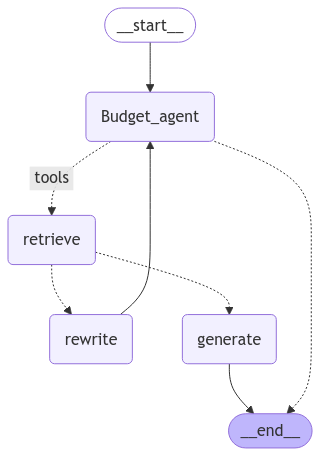

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [22]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about the types of agent memory?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

InvalidUpdateError: Must write to at least one of ['question', 'generation', 'documents']